# Price Optimisation Engine
I'm sure you have heard of dynamic pricing before, this system aims to maximise the price that you can sell a product for based on current demand. This remains a very powerful tool which can increase the profits of a company by bringing the margins on a product close to optimal.

But what if the demand doesn't match the supply at that price? Or what if demand dips in the winter? What if your competitor is charging less / more? 

This is where a Price Optimisation Engine comes in. We don't just predict the best possible price to sell a product at, we take into account all of these factors and use them to **maximise revenue not margins**.

## How do we do this?
That sounds great right? But how do we do it?

1. Price Elasticity Modeling: We use historic sales data to model how demand changes with price (taking into account the seasonality, inflationary, etc).
2. Competitive Pricing Analysis: We analyse the competitor's pricing, and how that effects our demand.
3. Inventory Aware Pricing: Finally we bring it together, and select the optimal price, that will ensure we sell what we need to based on stock spoilage, demand drops, etc.

---

## The Dataset
I have selected a dataset has the monthly sales of products at different stores. It also includes competitor pricing, and the original price (if the product was discounted).

This will allow us to analyse how increases and decreases in price affect demand overall and within specific stores.

### Exploration:

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./data/Competition_Data.csv")

In [3]:
display(df.head(10))

,Index,Fiscal_Week_ID,Store_ID,Item_ID,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price
0,0,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,206.44
1,1,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,158.01
2,2,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,278.03
3,3,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,222.66
4,4,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,195.32
5,5,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,108.75
6,6,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,219.64
7,7,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,100.11
8,8,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,86.10
9,9,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,231.21


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Index                     100000 non-null  int64  
 1   Fiscal_Week_ID            100000 non-null  object 
 2   Store_ID                  100000 non-null  object 
 3   Item_ID                   100000 non-null  object 
 4   Price                     100000 non-null  float64
 5   Item_Quantity             100000 non-null  int64  
 6   Sales_Amount_No_Discount  100000 non-null  float64
 7   Sales_Amount              100000 non-null  float64
 8   Competition_Price         100000 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 6.9+ MB


None

**Observations:**

It looks like the data contains duplicates for the same item_id with what appears to be multiple competitor prices. To check this is what is happening, I will see how many distinct rows vs total rows we have when grouping by:
 - Fiscal_Week_ID
 - Store_ID
 - Item_ID
 - Price
 - Item_Quantity
 - Sales_Amount_No_Discount
 - Sales_Amount

The Sales_Amount and Sales_Amount_No_Discount don't seem to make much sense. I will be calculating the Sales_Amount manually.

In [5]:
# This should display any rows where the Competition_Price isn't the only difference between two rows.
df_row_counts = df.groupby(["Fiscal_Week_ID", "Store_ID", "Item_ID"]).nunique()
display(df_row_counts[df_row_counts["Index"] != df_row_counts["Competition_Price"]].head(10))

Index  Price  Item_Quantity  \
Fiscal_Week_ID Store_ID  Item_ID                                
2019-14        store_136 item_62     20      2              2   
               store_162 item_62     20      2              2   
               store_197 item_62     20      2              2   
               store_30  item_62     20      2              2   
               store_442 item_62     20      2              2   
               store_458 item_62     20      2              2   
               store_459 item_62     20      2              2   
               store_594 item_62     20      2              2   
               store_601 item_62     20      2              2   
               store_709 item_62     20      2              2   

                                  Sales_Amount_No_Discount  Sales_Amount  \
Fiscal_Week_ID Store_ID  Item_ID                                           
2019-14        store_136 item_62                         2             2   
               store_162 item_62                         2             2   
               store_197 item_62                         2             2   
               store_30  item_62                         2             2   
               store_442 item_62                         2             2   
               store_458 item_62                         2             2   
               store_459 item_62                         2             2   
               store_594 item_62                         2             2   
               store_601 item_62                         2             2   
               store_709 item_62                         2             2   

                                  Competition_Price  
Fiscal_Week_ID Store_ID  Item_ID                     
2019-14        store_136 item_62                 19  
               store_162 item_62                 19  
               store_197 item_62                 19  
               store_30  item_62                 19  
               store_442 item_62                 19  
               store_458 item_62                 19  
               store_459 item_62                 19  
               store_594 item_62                 19  
               store_601 item_62                 19  
               store_709 item_62                 19

In [6]:
# Lets take a look at one of these records
display(df[
    (df["Fiscal_Week_ID"] == "2019-14" )
    & (df["Store_ID"] == "store_136")
    & (df["Item_ID"] == "item_62")
].head(10))

,Index,Fiscal_Week_ID,Store_ID,Item_ID,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price
70157,70157,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,71.55
70158,70158,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,120.44
70159,70159,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,157.00
70160,70160,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,100.09
70161,70161,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,120.44
70162,70162,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,154.86
70163,70163,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,121.77
70164,70164,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,195.88
70165,70165,2019-14,store_136,item_62,207.33,466,5435.12,12203.05,224.65
78533,78533,2019-14,store_136,item_62,88.40,327,3693.99,10490.63,270.39


**Feature Engineering:**

I am removing the Sales_Amount and Sales_Amount_No_Discount as they don't seem to be calculated properly. I will instead be calculating Sales_Amount myself.

In [7]:
df_pricing = df[["Fiscal_Week_ID","Store_ID","Item_ID", "Price", "Item_Quantity", "Competition_Price"]].copy()
df_pricing["Sales_Amount"] = df["Price"] * df["Item_Quantity"]

display(df_pricing.head(10))

,Fiscal_Week_ID,Store_ID,Item_ID,Price,Item_Quantity,Competition_Price,Sales_Amount
0,2019-11,store_459,item_526,134.49,435,206.44,58503.15
1,2019-11,store_459,item_526,134.49,435,158.01,58503.15
2,2019-11,store_459,item_526,134.49,435,278.03,58503.15
3,2019-11,store_459,item_526,134.49,435,222.66,58503.15
4,2019-11,store_459,item_526,134.49,435,195.32,58503.15
5,2019-11,store_459,item_526,134.49,435,108.75,58503.15
6,2019-11,store_459,item_526,134.49,435,219.64,58503.15
7,2019-11,store_459,item_526,134.49,435,100.11,58503.15
8,2019-11,store_459,item_526,134.49,435,86.10,58503.15
9,2019-11,store_459,item_526,134.49,435,231.21,58503.15


Now I will calculate the aggregate columns for a week, store, and item. 

In [8]:
import numpy as np

In [9]:
def weighted_median(values, weights):
    """Calculate quantity-weighted median"""
    mask = ~(np.isnan(values) | np.isnan(weights))
    values = values[mask]
    weights = weights[mask]
    
    if len(values) == 0:
        return np.nan
    
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    cumsum = np.cumsum(sorted_weights)
    total = np.sum(sorted_weights)
    cutoff = total / 2.0
    
    median_idx = np.searchsorted(cumsum, cutoff)
    return sorted_values[median_idx]

In [10]:
# Aggregate columns for the competition pricing
df_pricing_agg = df_pricing.groupby(
    ["Fiscal_Week_ID","Store_ID","Item_ID","Price","Item_Quantity","Sales_Amount"]
).agg({
    'Competition_Price':[
        'min',
        'max',
        'mean',
        'median'
    ]
})

df_pricing_agg.columns = ['_'.join(col).strip() for col in df_pricing_agg.columns.values]
df_pricing_agg.reset_index()

# Merge back
df_pricing_agg = df_pricing.drop_duplicates(
    subset=["Fiscal_Week_ID", "Store_ID", "Item_ID", "Price", "Item_Quantity", "Sales_Amount"]
).merge(
    df_pricing_agg,
    left_on=["Fiscal_Week_ID", "Store_ID", "Item_ID", "Price", "Item_Quantity", "Sales_Amount"],
    right_index=True
)

# Aggregate the store and item pricing and sales, weighted by the quantity
df_final = df_pricing_agg.groupby(
    ["Fiscal_Week_ID", "Store_ID", "Item_ID"]
).apply(lambda g: pd.Series({
    'Price_weighted_mean': (g['Price'] * g['Item_Quantity']).sum() / g['Item_Quantity'].sum(),
    'Price_weighted_median': weighted_median(g['Price'].values, g['Item_Quantity'].values),
    'Price_min': g['Price'].min(),
    'Price_max': g['Price'].max(),
    'Total_Quantity': g['Item_Quantity'].sum(),
    'Total_Sales': g['Sales_Amount'].sum(),
    'Competition_Price_min': g['Competition_Price_min'].iloc[0],
    'Competition_Price_max': g['Competition_Price_max'].iloc[0],
    'Competition_Price_mean': g['Competition_Price_mean'].iloc[0],
    'Competition_Price_median': g['Competition_Price_median'].iloc[0],
    'Num_Price_Points': len(g)
}), include_groups=False).reset_index()

# More features
# Get the logs of quantity (Q) and price (P)
df_final['log_quantity'] = np.log(df_final['Total_Quantity']+1)
df_final['log_price'] = np.log(df_final['Price_weighted_mean'])

# Get the log of competition_price mean
df_final['log_competition_price'] = np.log(df_final['Competition_Price_mean'])

# Create some features for time
df_final['fiscal_year'] = df_final['Fiscal_Week_ID'].str[:4].astype(int)
df_final['fiscal_week'] = df_final['Fiscal_Week_ID'].str[-2:].astype(int)

# Remove 26 weeks from the Fiscal Week to get to the estimated actual week of the year
df_final['year'] = np.where(df_final['fiscal_week'] <= 26, df_final['fiscal_year'] - 1, df_final['fiscal_year'])

df_final['week'] = np.where(df_final['fiscal_week'] <= 26, 52 + df_final['fiscal_week'] - 26, df_final['fiscal_week'] - 26)

# Create Week_End dates
df_final['Week_End'] = pd.to_datetime(
    df_final['year'].astype(str) + '-W' + df_final['week'].astype(str).str.zfill(2) + '-7',
    format='%G-W%V-%u'
)

df_final['week_sin'] = np.sin(2 * np.pi * df_final['week'] / 52)
df_final['week_cos'] = np.cos(2 * np.pi * df_final['week'] / 52)

# Display a sample of the final data
display(df_final.head(10))

,Fiscal_Week_ID,Store_ID,Item_ID,Price_weighted_mean,Price_weighted_median,Price_min,Price_max,Total_Quantity,Total_Sales,Competition_Price_min,...,log_quantity,log_price,log_competition_price,fiscal_year,fiscal_week,year,week,Week_End,week_sin,week_cos
0,2019-11,store_136,item_1,106.69,106.69,106.69,106.69,408.0,43529.52,123.35,...,6.013715,4.669927,5.394862,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
1,2019-11,store_136,item_11,204.30,204.30,204.30,204.30,487.0,99494.10,127.12,...,6.190315,5.319590,5.301324,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
2,2019-11,store_136,item_117,56.29,56.29,56.29,56.29,421.0,23698.09,86.17,...,6.045005,4.030517,5.107364,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
3,2019-11,store_136,item_119,109.66,109.66,109.66,109.66,480.0,52636.80,70.31,...,6.175867,4.697385,5.317511,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
4,2019-11,store_136,item_125,292.77,292.77,292.77,292.77,296.0,86659.92,68.31,...,5.693732,5.679387,5.078073,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
5,2019-11,store_136,item_128,81.14,81.14,81.14,81.14,420.0,34078.80,157.79,...,6.042633,4.396176,5.314914,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
6,2019-11,store_136,item_137,136.70,136.70,136.70,136.70,411.0,56183.70,96.97,...,6.021023,4.917789,5.095258,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
7,2019-11,store_136,item_139,75.65,75.65,75.65,75.65,397.0,30033.05,55.38,...,5.986452,4.326117,5.160587,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
8,2019-11,store_136,item_150,114.80,114.80,114.80,114.80,370.0,42476.00,102.07,...,5.916202,4.743191,5.171603,2019,11,2018,37,2018-09-16,-0.970942,-0.239316
9,2019-11,store_136,item_152,102.74,102.74,102.74,102.74,332.0,34109.68,65.62,...,5.808142,4.632202,4.907125,2019,11,2018,37,2018-09-16,-0.970942,-0.239316


In [11]:
unique_shop_items = df_final[["Store_ID","Item_ID"]].drop_duplicates().values.tolist()

---

## Price Elasticity Modeling
Our first step in our Price Optimisation Engine is to model the price elasticity. Basically, we want to know how a % change in price drives a % change in demand.


### How?
There is a standard model for calculating price elasticity. The formula is fairly simple:

```
Price Elasticity = (% change in demand) / (% change in price)
```

The issue with this model is that you have to account for external factors before calculating it. This means we need to know the market growth, inflation, etc. 

For our dataset this isn't possible as we don't know the industry or location of the stores.

For this reason I have chosen to use **Log-Log Price Elasticity**. This model assumes that there is a linear relationship between the change in demand and the change in price. The formula for this is below:

```
ln(Q)=β0​+β1​ln(P)+ϵ

Where
Q = demand for a product
P = price of the product
β0 = estimated coeficient​
β1​ = estimated coeficient​
ϵ = sum of external factors
```

We can implement this using a linear regression model. For the sake of transparency I have implemented it in both scikit-learn and statsmodels. As statsmodels gives us more details about the model like P-Values.

_Note that the source of our data is for a Price Optimisation Model, but they use the normal PED formula without accounting for external factors._


### Results:



### Sources:
 - https://publications.pricingsociety.com/understanding-price-elasticity-models-a-comprehensive-cutting-edge-guide/
 - https://amanxai.com/2024/07/22/price-optimization-using-python/



### OLS Model
We are using the ols formula API here to simplify the creation of the model, we will try a few different configurations and analyse the statistics to select the best one.

In [12]:
from statsmodels.formula.api import ols

In [13]:
model_1 = ols('log_quantity ~ log_price', data=df_final).fit()
print(model_1.summary())

model_1_PED = model_1.params['log_price']
model_1_pvalue = model_1.pvalues['log_price']
print(f"\nP-Value: {model_1_pvalue:.5f}")

                            OLS Regression Results                            
Dep. Variable:           log_quantity   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     15.76
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           7.26e-05
Time:                        00:00:29   Log-Likelihood:                -1373.7
No. Observations:                8800   AIC:                             2751.
Df Residuals:                    8798   BIC:                             2765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2072      0.034    183.178      0.0

In [14]:
model_2 = ols('log_quantity ~ log_price + log_competition_price', data=df_final).fit()
print(model_2.summary())

model_2_PED = model_2.params['log_price']
model_2_pvalue = model_2.pvalues['log_price']
print(f"\nP-Value: {model_2_pvalue:.5f}")

                            OLS Regression Results                            
Dep. Variable:           log_quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     12.80
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           2.82e-06
Time:                        00:00:29   Log-Likelihood:                -1368.8
No. Observations:                8800   AIC:                             2744.
Df Residuals:                    8797   BIC:                             2765.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.83

In [15]:
model_3 = ols('log_quantity ~ log_price + log_competition_price + week_sin + week_cos', data=df_final).fit()
print(model_3.summary())

model_3_PED = model_3.params['log_price']
model_3_pvalue = model_3.pvalues['log_price']
print(f"\nP-Value: {model_3_pvalue:.5f}")

                            OLS Regression Results                            
Dep. Variable:           log_quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.398
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           3.89e-05
Time:                        00:00:29   Log-Likelihood:                -1368.8
No. Observations:                8800   AIC:                             2748.
Df Residuals:                    8795   BIC:                             2783.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.83

In [16]:
model_4 = ols('log_quantity ~ log_price + log_competition_price + week_sin + week_cos + C(Store_ID)', data=df_final).fit()
print(model_4.summary())

model_4_PED = model_4.params['log_price']
model_4_pvalue = model_4.pvalues['log_price']
print(f"\nP-Value: {model_4_pvalue:.5f}")

                            OLS Regression Results                            
Dep. Variable:           log_quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.971
Date:                Fri, 21 Nov 2025   Prob (F-statistic):             0.0192
Time:                        00:00:29   Log-Likelihood:                -1368.7
No. Observations:                8800   AIC:                             2765.
Df Residuals:                    8786   BIC:                             2865.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [17]:
model_5 = ols('log_quantity ~ log_price + log_competition_price + week_sin + week_cos + C(Store_ID) + C(Item_ID)', data=df_final).fit()
print(model_5.summary())

model_5_PED = model_5.params['log_price']
model_5_pvalue = model_5.pvalues['log_price']
print(f"\nP-Value: {model_5_pvalue:.5f}")

                            OLS Regression Results                            
Dep. Variable:           log_quantity   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     4790.
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        00:00:29   Log-Likelihood:                 19120.
No. Observations:                8800   AIC:                        -3.786e+04
Df Residuals:                    8611   BIC:                        -3.652e+04
Df Model:                         188                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Model Selection
1. Firstly we want to maximise R-squared because it means that our model is able to predict more of the variance in the data
2. We also want to minimise AIC because it means that our model isn't being overfit
3. We need to make sure the p-value is significant between our features and our target (less than 0.05) as it means that the model is better than random

In [18]:
comparison = pd.DataFrame({
    'Model': [
        '1. Simple',
        '2. + Competition',
        '3. + Time',
        '4. + Store',
        '5. + Item'
    ],
    'PED': [
        model_1_PED,
        model_2_PED,
        model_3_PED,
        model_4_PED,
        model_4_PED
    ],
    'R-squared': [
        model_1.rsquared,
        model_2.rsquared,
        model_3.rsquared,
        model_4.rsquared,
        model_5.rsquared
    ],
    'AIC': [
        model_1.aic,
        model_2.aic,
        model_3.aic,
        model_4.aic,
        model_5.aic
    ],
    'p-value log_price': [
        model_1.pvalues['log_price'],
        model_2.pvalues['log_price'],
        model_3.pvalues['log_price'],
        model_4.pvalues['log_price'],
        model_5.pvalues['log_price']
    ],
    'p-value competition_price': [
        None,
        model_2.pvalues['log_competition_price'],
        model_3.pvalues['log_competition_price'],
        model_4.pvalues['log_competition_price'],
        model_5.pvalues['log_competition_price']
    ],
    'p-value week_sin': [
        None,
        None,
        model_3.pvalues['week_sin'],
        model_4.pvalues['week_sin'],
        model_5.pvalues['week_sin']
    ],
    'p-value week_cos': [
        None,
        None,
        model_3.pvalues['week_cos'],
        model_4.pvalues['week_cos'],
        model_5.pvalues['week_cos']
    ]
})

display(comparison)

,Model,PED,R-squared,AIC,p-value log_price,p-value competition_price,p-value week_sin,p-value week_cos
0,1. Simple,-0.026674,0.001788,2751.326588,0.000073,NaN,NaN,NaN
1,2. + Competition,-0.026189,0.002901,2743.505715,0.000098,0.001729,NaN,NaN
2,3. + Time,-0.026188,0.002901,2747.504352,0.000098,0.001733,0.987747,0.973228
3,4. + Store,-0.026190,0.002908,2765.443099,0.000099,0.001743,0.987753,0.973242
4,5. + Item,-0.026190,0.990527,-37861.200889,0.778320,0.532278,0.986027,0.573370


So the first thing we need to address is that the 5th model which includes the Item_ID has fallen apart. the p-values are way to high, and the AIC score doesn't make a lot of sense. So we will ignore that one for now.

We can see the best R-squared is model 4 but model 2 and model 3 have lower AIC. Any of these would be good choices, but I have decided to go with model 4.

In [19]:
best_PED = model_4_PED

---

## Price Optimisation Engine
Now that we know the PED for our data, we can create our engine, our goal is to have a function that we can run to find the optimal price for the next few weeks.

To do this, we need to do two more things
1. Predict the baseline demand for a product (we can use Prophet here, an open source model from Meta)
2. Use an optimisation model to select the best price to maximise the revenue

In [20]:
from prophet import Prophet

In [21]:
X = df_final.copy()

# Renaming the date and target column to allow Prophet to correctly identify them
X["ds"] = X["Week_End"]
X["y"] = X["Total_Quantity"]

# Now we can forecast the demand for each store and item combination for the 8 week period
forecast_all = []
for (store_id, item_id), group in X.groupby(['Store_ID', 'Item_ID']):
    # We add regressors for the features that we previously proved affect demand, but also change over time
    m = Prophet()
    m.add_regressor("Price_weighted_mean")
    m.add_regressor("Competition_Price_mean")
    m.fit(group)

    # We then create a dataframe with 4 weeks into the future of the dataset
    future = m.make_future_dataframe(periods=4, freq='W', include_history=True)
    future = future.merge(
        group[['ds', 'Price_weighted_mean', 'Competition_Price_mean']], 
        on='ds', 
        how='left'
    )

    # Get the latest Price and Competition Price
    future['Price_weighted_mean'].fillna(group['Price_weighted_mean'].iloc[-1], inplace=True)
    future['Competition_Price_mean'].fillna(group['Competition_Price_mean'].iloc[-1], inplace=True)

    # Predict the forecast for the future period
    forecast = m.predict(future)[["ds","trend","yhat_lower","yhat_upper","trend_lower","trend_upper","yhat"]]
    forecast["Store_ID"] = store_id
    forecast["Item_ID"] = item_id
    forecast = forecast.merge(
        group[['ds', 'Price_weighted_mean', 'Competition_Price_mean']],
        on='ds',
        how='left'
    )

    forecast['Price_weighted_mean'].fillna(group['Price_weighted_mean'].iloc[-1], inplace=True)
    forecast['Competition_Price_mean'].fillna(group['Competition_Price_mean'].iloc[-1], inplace=True)

    # Add the forecast to a list of all forecasts
    forecast_all.append(forecast)

    break

# Combine the list of dataframes into a single dataframe
forecast_all = pd.concat(forecast_all)

00:00:30 - cmdstanpy - INFO - Chain [1] start processing
00:00:31 - cmdstanpy - INFO - Chain [1] done processing


Lets look at one of these items and see what the demand was and is forecast to be in the future, then we can add the PED.

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

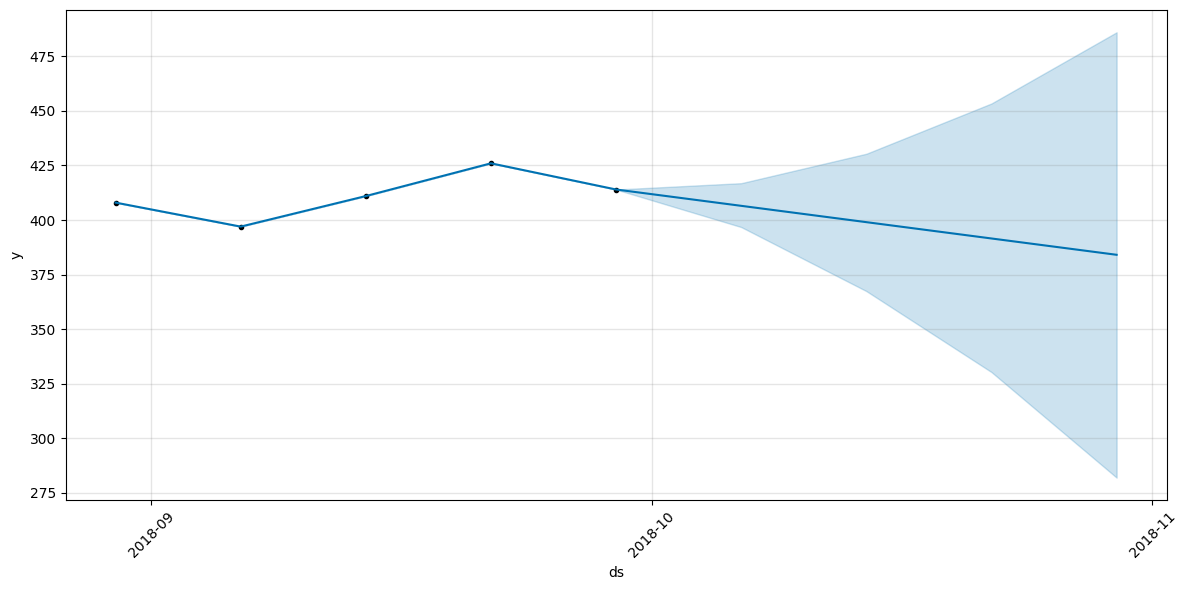

In [26]:
df_shop_item_future = forecast_all[
    (forecast_all["Store_ID"] == "store_136")
    & (forecast_all["Item_ID"] == "item_1")
]

fig, ax = plt.subplots(figsize=(12, 6))

m.plot(df_shop_item_future, ax=ax)

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

# Ticks every 4 weeks:
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))  # Every 4 weeks

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now we apply the calculated PED and optimise our prices for the best possible 4 week period of revenue

In [ ]:
from scipy.optimize import minimize_scalar

In the future we would want to do the next steps in the same loop as the training, but for clarity I am doing a second similar loop

In [43]:
all_optimal_prices = []
for (store_id, item_id), group in forecast_all.groupby(['Store_ID', 'Item_ID']):
    future_forecast = group[-4:].copy()

    ref_price = group.iloc[-5]["Price_weighted_mean"]
    baselines = group[-4:]['yhat'].values

    current_price = ref_price

    optimal_prices = []
    for baseline in baselines:
        def neg_revenue(test_price):
            demand = baseline * (test_price / current_price) ** best_PED
            return -(test_price * demand)
        
        result = minimize_scalar(neg_revenue, bounds=(current_price*0.5, current_price*1.5), method='bounded')
        optimal_prices.append(result.x)
        current_price = result.x
    
    expected_demands = baselines * (optimal_prices / ref_price) ** best_PED
    expected_revenues = optimal_prices * expected_demands

    future_forecast["optimal_price"] = optimal_prices
    future_forecast["expected_demand"] = expected_demands
    future_forecast["expected_revenue"] = expected_revenues

    all_optimal_prices.append(
        future_forecast
    )

all_optimal_prices = pd.concat(all_optimal_prices)
display(all_optimal_prices.head(10))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,yhat,Store_ID,Item_ID,Price_weighted_mean,Competition_Price_mean,optimal_price,expected_demand,expected_revenue
5,2018-10-21,405.714298,396.795571,416.897789,395.987426,416.089643,406.522444,store_136,item_1,102.35,152.08,153.524993,402.228416,61752.114527
6,2018-10-28,398.236741,367.457850,430.382766,366.649705,429.574621,399.044887,store_136,item_1,102.35,152.08,230.287477,390.659322,89963.949541
7,2018-11-04,390.759184,330.352377,453.424732,329.544232,452.616586,391.567330,store_136,item_1,102.35,152.08,345.431206,379.289755,131018.517253
8,2018-11-11,383.281627,282.001747,486.037410,281.193602,485.229265,384.089773,store_136,item_1,102.35,152.08,518.146793,368.116790,190738.533955


### Analysis
Because our PED indicates that the correlation between demand and price is quite small we end up pushing the price up every week.


## Next Steps

- Scenario analysis - what if competitor drops price 10%? What if demand forecast is wrong?
- Sensitivity analysis - how sensitive is optimal price to PED estimate? To cost assumptions?
- Segmentation - are optimal prices different by store/item/time?
- Revenue impact projection - how much revenue lift from optimal vs current pricing?
- Visualizations - price curves, demand curves, revenue optimization plots
- Business recommendations - which products to reprice first? Implementation strategy?
